In [ ]:
from pathlib import Path
import kagglehub
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
DATA_DIR = Path(kagglehub.dataset_download("ravirajsinh45/real-life-industrial-dataset-of-casting-product"))

In [ ]:
DATA_DIR

PosixPath('/Users/anatolii/.cache/kagglehub/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product/versions/2')

In [ ]:
# count defect and ok images in train and test sets
train_defect = len(list((DATA_DIR / "casting_data" / "casting_data" / "train" / "def_front").glob("*.jpeg")))
train_ok = len(list((DATA_DIR / "casting_data" / "casting_data" / "train" / "ok_front").glob("*.jpeg")))

test_defect = len(list((DATA_DIR / "casting_data" / "casting_data" / "test" / "def_front").glob("*.jpeg")))
test_ok = len(list((DATA_DIR / "casting_data" / "casting_data" / "test" / "ok_front").glob("*.jpeg")))

In [ ]:
train_defect_ratio = train_defect / (train_defect + train_ok)
train_ok_ratio = 1 - train_defect_ratio

test_defect_ratio = test_defect / (test_defect + test_ok)
test_ok_ratio = 1 - test_defect_ratio

In [ ]:
print(f"Train | Defect: {train_defect} [{train_defect_ratio:.2%}], OK: {train_ok} [{train_ok_ratio:.2%}]")
print(f"Test  | Defect: {test_defect}  [{test_defect_ratio:.2%}], OK: {test_ok}  [{test_ok_ratio:.2%}]")

Train | Defect: 3758 [56.66%], OK: 2875 [43.34%]
Test  | Defect: 453  [63.36%], OK: 262  [36.64%]


In [ ]:
print(f"Test size: {(test_defect + test_ok) / (train_defect + train_ok)}")

Test size: 0.1077943615257048


In [ ]:
# Load one image
img_path = (DATA_DIR / "casting_data" / "casting_data" / "train" / "ok_front" / "cast_ok_0_1.jpeg")
img = Image.open(img_path)

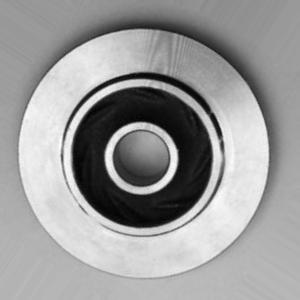

In [ ]:
img

In [ ]:
img.size, img.mode

((300, 300), 'RGB')

In [ ]:
img_gray_resized = img.convert('L').resize((224, 224), Image.LANCZOS)

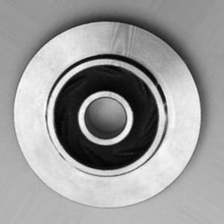

In [ ]:
img_gray_resized

In [ ]:
img_gray_resized.mode

'L'

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def create_manifest(data_path):
    data = []
    for split in ["train", "test"]:
        for label_folder in ["def_front", "ok_front"]:
            label = 1 if label_folder == "def_front" else 0
            folder_path = data_path / split / label_folder
            for file_path in folder_path.glob("*.jpeg"):
                data.append({
                    "file_path": str(file_path),
                    "defect": label,
                    "split": split
                })  
    return pd.DataFrame(data)

In [ ]:
def build_dataframes(df: pd.DataFrame):
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]
    df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 16, stratify=df_train["defect"])
    df_val["split"] = "val"
    return df_train, df_val, df_test


In [ ]:
df = create_manifest(DATA_DIR / "casting_data" / "casting_data")

In [ ]:
df_train = df[df["split"] == "train"]

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 16, stratify=df_train["defect"])

In [ ]:
df_train.shape, df_val.shape

((5306, 3), (1327, 3))

In [ ]:
df_val["split"] = "val"

In [ ]:
from torchvision.transforms import v2
import torch
from torch.utils.data import Dataset
from typing import Tuple, Optional, Callable

In [ ]:
def build_transforms(img_size: int, img_mode: str, train: bool):
    # check img mode
    if img_mode not in {"RGB", "L"}:
        raise ValueError(img_mode)
    
    # Normalizatoin (compute later dataset std and mean)
    if img_mode == "RGB":
        mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    else:
        mean, std = (0.5,), (0.5,) # 1 channel for "L"

    ops = v2.Resize((img_size, img_size))

    # augment if train set:
    if train: 
        ops += [
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.2, contrast=0.2)
        ]
    ops += [
        v2.ToTensor(),
        v2.Normalize(mean, std)
    ]
    return v2.Compose(ops)
    

In [ ]:
from dataclasses import dataclass
# for now 
@dataclass(frozen=True)
class DatasetConfig:
    img_mode: str = "RGB"   # "RGB" or "L"
    img_size: int = 224       # final H=W
    label_col: str = "defect"
    path_col: str = "file_path"
    subset_col: str = "subset"  # or "split" if you keep that naming


In [ ]:

class CastingQCDataset(Dataset):
    def __init__(self, cfg, df: pd.DataFrame, subset: str, transform: Optional[Callable] = None):
        self.cfg = cfg
        self.transform = transform
        self.subset = subset
        # Filter once and reset index so __getitem__ is stable
        self.df = df[df["split"] == subset].reset_index(drop=True)
    
    def __len__(self) -> int:
        return len(self.df)

    def _getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        row = self.df.iloc[idx]
        path = row[self.cfg.path_col]
        y = row[self.cfg.label_col]
        img = Image.open(path)
        img = img.convert(self.cfg.img_mode)
        x = self.transform(img)

        return x, torch.tensor(dtype=torch.long)


In [ ]:
def build_loader(cfg, df: pd.DataFrame, train: bool):
    # create transformers
    train_trasform = build_transforms(cfg, train=True)
    test_transform = build_transforms(cfg, train=False)

In [ ]:
df_train[df_train["defect"] == 1].count()

file_path    3006
defect       3006
split        3006
dtype: int64

In [ ]:
df_train[df_train["defect"] == 0].count()

file_path    2300
defect       2300
split        2300
dtype: int64

In [ ]:
df_train.shape

(5306, 3)